In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#call library

import os
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, LSTM, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt
import json

In [ ]:
base_path = '/content/drive/MyDrive/research/valueclassifier/'

In [ ]:
def preprocessEach(folder_name):
   # set file path
    folder_path = '/content/drive/MyDrive/research/valueclassifier/' + f'data/{folder_name}_clean'

    # load file name in folder
    file_names = os.listdir(folder_path)
    data_array = []

    for file in file_names:
        # set file path
        file_path = os.path.join(folder_path, file)
        
        # load csv file as dataframe
        df = pd.read_csv(file_path)

        #preprocessing column
        df['Diff'] = df['High'] - df['Low']
        df = df[['Close','Volume','Diff', 'Search']]
        df.fillna(0, inplace=True)

        #log transform
        df = np.log1p(df)

        #insert list to array
        data_array.append(df)

    return np.array(data_array)

In [ ]:
xGrowths = preprocessEach('growth')
xValues = preprocessEach('value')
xOverlaps = preprocessEach('overlap')

<ipython-input-4-d5b3a29cf80c>:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.fillna(0, inplace=True)


In [ ]:
def bootstrap(large, small):
    diff = len(large) - len(small)
    bootstrapped = small[np.random.choice(len(small), size=diff, replace=True)]
    return np.concatenate((small, bootstrapped), axis=0)

In [ ]:
# xValuesAll = np.concatenate((xValues, xOverlaps), axis=0)

In [ ]:
xGrowths = bootstrap(xValues, xGrowths)

In [ ]:
def makeYValue(folder_name, filelength):

    if folder_name=='growth':
        yValues = np.zeros(filelength)
    elif folder_name=='value':
        yValues = np.ones(filelength)

    y = np.column_stack([yValues.T])
    return y

In [ ]:
#make y values
yGrowths = makeYValue('growth', len(xGrowths))
yValues = makeYValue('value', len(xValues))

In [ ]:
x = np.concatenate((xGrowths, xValues), axis=0)
y = np.concatenate((yGrowths, yValues), axis=0)

In [ ]:
#minmax scaling by element
scaler = MinMaxScaler()
for i in range(4):
    x[:,:,i] = scaler.fit_transform(x[:,:,i])

In [ ]:
def splitData(x, y, train_ratio=0.8):
    # shuffle data
    permutation = np.random.permutation(len(x))
    x = x[permutation]
    y = y[permutation]

    # split data
    n_train_samples = int(train_ratio * len(x))
    x_train, x_test = x[:n_train_samples], x[n_train_samples:]
    y_train, y_test = y[:n_train_samples], y[n_train_samples:]

    return x_train, x_test, y_train, y_test

In [ ]:
x_train, x_test, y_train, y_test = splitData(x, y)

In [ ]:
#modify NaN to 0
x_train = np.nan_to_num(x_train, nan=0)
x_test = np.nan_to_num(x_test, nan=0)

In [ ]:
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

In [ ]:
x_train.shape #1713 data samples, 1248 days, 6 features

(1713, 1248, 4)

## Baseline model

In [ ]:
model = Sequential()
model.add(LSTM(64, input_shape=(1248,4), return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(16))
model.add(Dense(2, activation='softmax'))
# es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=200)
mc = ModelCheckpoint('best_model_value.h5', monitor='val_acc', mode='max', save_best_only=True)
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['acc'])

In [ ]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_2 (LSTM)               (None, 1248, 64)          17664     
                                                                 
 dropout_2 (Dropout)         (None, 1248, 64)          0         
                                                                 
 lstm_3 (LSTM)               (None, 16)                5184      
                                                                 
 dense_1 (Dense)             (None, 2)                 34        
                                                                 
Total params: 22,882
Trainable params: 22,882
Non-trainable params: 0
_________________________________________________________________


In [ ]:
#split data for cross validation
def splitDataCrossVal(x, y, fold=3):
    # shuffle data
    permutation = np.random.permutation(len(x))
    x = x[permutation]
    y = y[permutation]

    x_split = []
    y_split = []
    # split data
    n_samples = int(len(x)/fold)
    for i in range(fold-1):
      x_split.append(x[i*n_samples:(i+1)*n_samples])
      y_split.append(y[i*n_samples:(i+1)*n_samples])
    x_split.append(x[(fold-1)*n_samples:])
    y_split.append(y[(fold-1)*n_samples:])

    return x_split, y_split

In [24]:
#cross validation
x_split, y_split = splitDataCrossVal(x_train,y_train)
print(len(x_split))
accuracy_cross_val = []
for i in range(len(x_split)):
  x_train_cv, x_val, y_train_cv, y_val = splitData(x_split[i], y_split[i])
  x_train_cv = np.nan_to_num(x_train_cv, nan=0)
  x_val = np.nan_to_num(x_val, nan=0)

  history=model.fit(x_train_cv, y_train_cv, epochs=1500, validation_data=(x_val, y_val), callbacks=[mc])
  model=load_model('best_model_value.h5')
  loss, accuracy = model.evaluate(x_val, y_val)
  accuracy_cross_val.append(accuracy)
  with open(f'history_value{i}.json', 'w') as f:
      json.dump(history.history, f)
print("cross validation accuracy:{}".format(accuracy_cross_val))
print("average cross validation accuracy:{}".format(sum(accuracy_cross_val)/len(accuracy_cross_val)))

스트리밍 출력 내용이 길어서 마지막 5000줄이 삭제되었습니다.
Epoch 503/1500
15/15 [==============================] - 1s 80ms/step - loss: 0.6594 - acc: 0.5680 - val_loss: 0.6470 - val_acc: 0.5565
Epoch 504/1500
15/15 [==============================] - 1s 81ms/step - loss: 0.6539 - acc: 0.6184 - val_loss: 0.6470 - val_acc: 0.5652
Epoch 505/1500
15/15 [==============================] - 1s 79ms/step - loss: 0.6511 - acc: 0.5965 - val_loss: 0.6426 - val_acc: 0.5913
Epoch 506/1500
15/15 [==============================] - 1s 79ms/step - loss: 0.6652 - acc: 0.5768 - val_loss: 0.6918 - val_acc: 0.5217
Epoch 507/1500
15/15 [==============================] - 1s 81ms/step - loss: 0.6841 - acc: 0.5504 - val_loss: 0.6841 - val_acc: 0.5304
Epoch 508/1500
15/15 [==============================] - 1s 79ms/step - loss: 0.6639 - acc: 0.6250 - val_loss: 0.6587 - val_acc: 0.5391
Epoch 509/1500
15/15 [==============================] - 1s 92ms/step - loss: 0.6584 - acc: 0.6009 - val_loss: 0.6549 - val_acc: 0.5739
Epoch 510/1500
15/1

In [25]:
hiostory_dict_list = []
for i in range(len(x_split)):
    with open(f'history_value{i}.json', 'r') as f:
        hiostory_dict_list.append(json.load(f))

In [26]:
count_01 = np.sum((y_test == [0,1]).all(axis=1))
count_10 = np.sum((y_test == [1,0]).all(axis=1))

print(f"[01]의 개수: {count_01}")
print(f"[10]의 개수: {count_10}")

[01]의 개수: 206
[10]의 개수: 223


In [27]:
best_model=load_model('best_model_value.h5')
loss, accuracy = best_model.evaluate(x_test, y_test)
y_pred_prob = best_model.predict(x_test)

14/14 [==============================] - 2s 52ms/step


In [28]:
def model_loss(history):
    epochs = range(1, len(history['val_acc']) + 1)
    plt.plot(epochs, history['loss'])
    plt.plot(epochs, history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper left')
    plt.show()

In [29]:
def model_acc(history):
    epochs = range(1, len(history['val_acc']) + 1)
    plt.plot(epochs, history['acc'])
    plt.plot(epochs, history['val_acc'])
    plt.title('model acc')
    plt.ylabel('acc')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper left')
    plt.show()

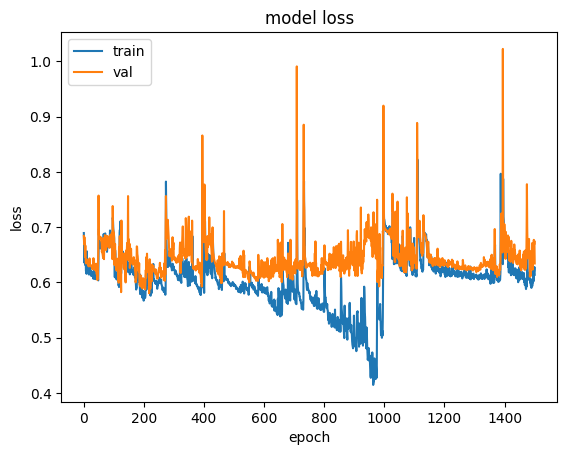

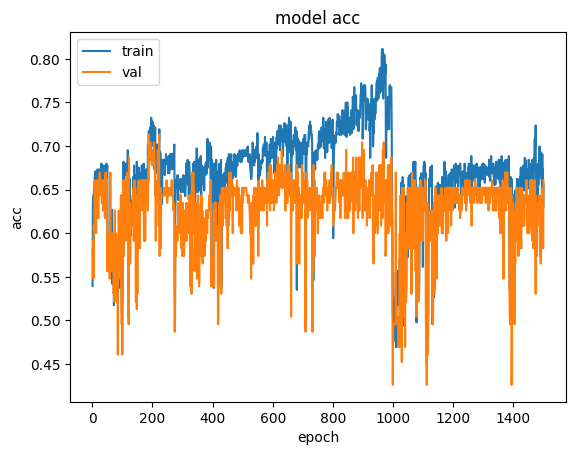

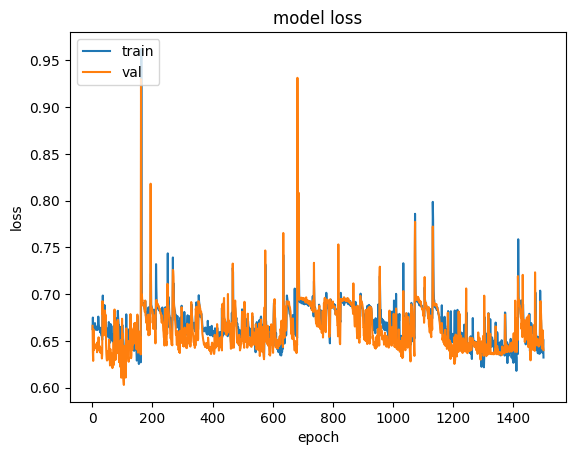

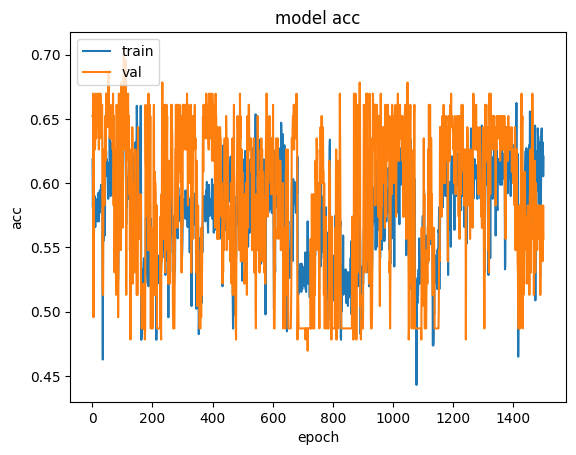

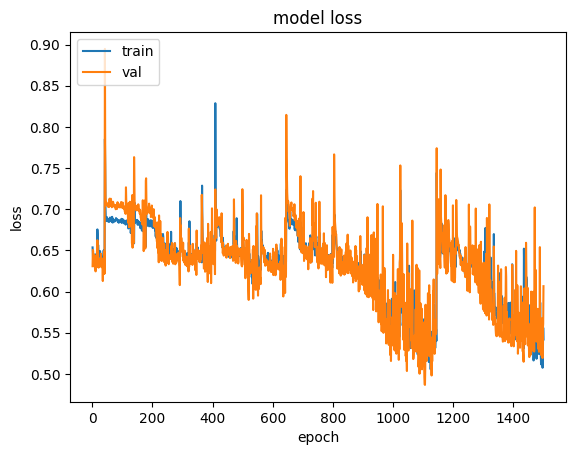

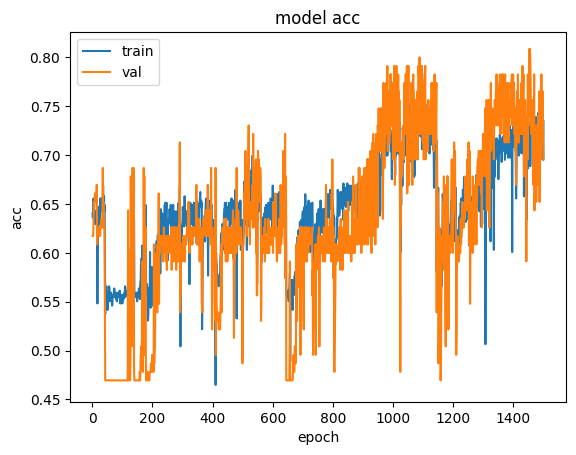

In [30]:
for i in hiostory_dict_list:
    model_loss(i)
    model_acc(i)

In [ ]:
with open('history0.json', 'r') as f:
    history_dict0 = json.load(f)
with open('history1.json', 'r') as f:
    history_dict1 = json.load(f)
with open('history2.json', 'r') as f:
    history_dict2 = json.load(f)

FileNotFoundError: ignored

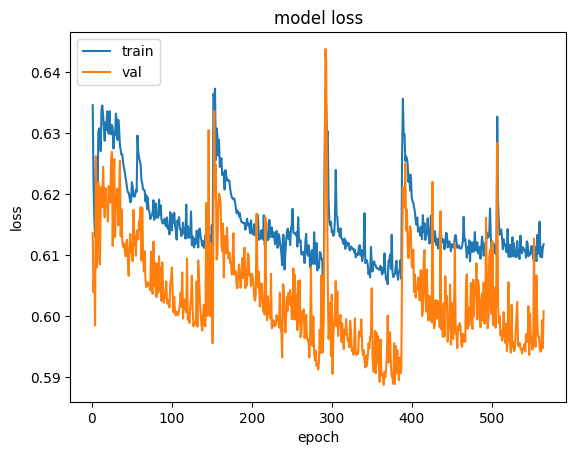

In [ ]:
epochs0 = range(1, len(history_dict0['acc']) + 1)
plt.plot(epochs0, history_dict0['loss'])
plt.plot(epochs0, history_dict0['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

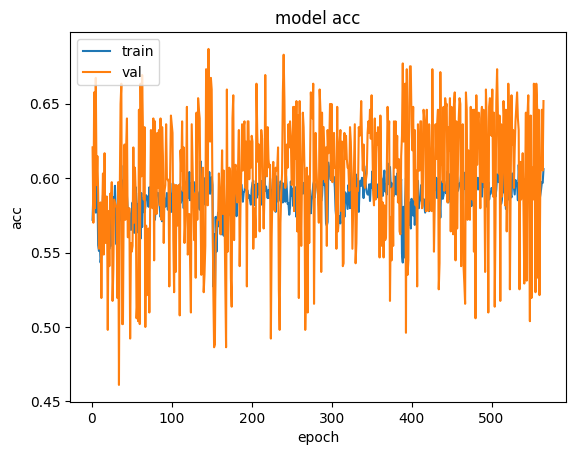

In [ ]:
epochs0 = range(1, len(history_dict0['acc']) + 1)
plt.plot(epochs0, history_dict0['acc'])
plt.plot(epochs0, history_dict0['val_acc'])
plt.title('model acc')
plt.ylabel('acc')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()